In [1]:
# https://deep-learning-study.tistory.com/534
# https://github.com/pytorch/examples/blob/3970e068c7f18d2d54db2afee6ddd81ef3f93c24/imagenet/main.py#L171
# https://ai.dreamkkt.com/54
# https://github.com/BerenMillidge/PredictiveCodingBackprop
# https://github.com/nalonso2/PredictiveCoding-MQSeqIL/tree/main
# https://github.com/ptrblck/pytorch_misc/blob/master/batch_norm_manual.py

In [2]:
# https://eehoeskrap.tistory.com/430 : batch normalization
# https://jay-chamber.tistory.com/entry/torchTensor%EC%97%90-%EB%8C%80%ED%95%98%EC%97%AC : .grad, .is_leaf, retain_graph, requires_grad 등 설명
# https://darkpgmr.tistory.com/132 : Jacobian, Hessian 설명
# https://math.stackexchange.com/questions/3643354/difference-between-vjp-and-jvp : Vector-Jacobian Product 설명
# https://pytorch.org/docs/stable/generated/torch.autograd.functional.vjp.html : Vector-Jacobian Product 설명
# https://tutorials.pytorch.kr/intermediate/jacobians_hessians.html

# https://codingalone.tistory.com/2 : colab 시 커스텀 모듈 import 하는 법

In [3]:

import torch
import torchvision.datasets as dsets
# torchvision.datasets 을 이용해 ImageNet 데이터셋을 관리
import torchvision.transforms as transforms
# MNIST등의 데이터셋에 들어있는 데이터들을 원하는 모양으로 변환할때 사용하는 모듈

from torch import FloatTensor
from torch import optim
# from torch import FloatTensor, optim 같이 한줄로 합쳐도 됨 (as로 새이름 정하지 않을경우)

from torch.optim.lr_scheduler import ReduceLROnPlateau
# 학습 진행이 느려지면 자동으로 lr값을 조정해주는 module

from torch.utils.data import DataLoader
# 미니배치 데이터 로딩을 도울 모듈

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import json
# n01443537 같이 되어있는 클래스 이름들을 goldfish 와 같이 쉽게 바꿔줄 때 사용할 파일이 JSON파일
import os
# os.path.join(save_path, filename) 으로 파일 경로 합칠 때 사용
import shutil
# shutil.copyfile(path_a, path_b) a 경로의 파일을 b 경로에 복사

import scipy


import torchsummary
# 모델 구조 표로 정리해서 보여주는 모듈
# torchsummary.summary(model, input_size=(3, 224, 224), batch_size=64) 와 같이 사용

from torchvision import models
# pretrained 된 모델들을 담고 있는 모듈

import torchvision.transforms.functional as visionF
# 이미지 표시에 쓰이는 visionF.to_pil_image(img) 함수등 여러 함수 포함

from torchvision.utils import make_grid
# 이미지들을 표시할 grid 생성


import time
import datetime
# 시간 측정에 사용

import math

import copy
# copy.deepcopy()로 깊은 복사 수행

In [4]:
from PClayers import *
from PClayersBN import *
from PCNet import *
from PCfunctions import *

In [5]:
USE_CUDA = torch.cuda.is_available() 
# GPU 사용가능하면 True 반환

device = torch.device('cuda' if USE_CUDA else 'cpu')
print(f"==>> device: {device}")

==>> device: cuda


In [6]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.247, 0.243, 0.262]),
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.247, 0.243, 0.262]),
])

# normalize 값 계산 : https://github.com/kuangliu/pytorch-cifar/issues/19

In [7]:
batch_size = 32

train_set = dsets.CIFAR10(root='../CIFAR10', train=True, download=True, transform=transform)
# train_set.data는 (50000, 32, 32, 3)꼴
# train_set.targets는 (50000,) 꼴

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

val_set = dsets.CIFAR10(root='../CIFAR10', train=False, download=True, transform=val_transform)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

print(len(train_loader.dataset))
print(len(val_loader.dataset))

Files already downloaded and verified
Files already downloaded and verified
50000
10000


In [8]:
# learning_rate = 0.00005
# testpcnet34 일때는 learning_rate가 엄청 작아야 한다
# (∵ BN이 없어서)
learning_rate = 0.01

def testpcnet34():
    return PCNet(PCBlockTest, [3,4,6,3], learning_rate=learning_rate, device=device)


def pcnet34():
    return PCNet(PCBlockBN, [3,4,6,3], learning_rate=learning_rate, device=device, n_iter_dx= 25)

def pcnet34_10():
    return PCNet(PCBlockBN, [3,4,6,3], learning_rate=learning_rate, device=device, n_iter_dx= 10)

In [9]:
# model = testpcnet34()
# model = pcnet34()
model = pcnet34_10()
# torchsummary.summary(model, (3,32,32), batch_size)

In [10]:
# # model.eval()
# # model.conv2_x.eval()
# for block in model.conv2_x.blocks:
#     block.eval()

# torchsummary.summary(model, (3,32,32), batch_size)
# # block 안에 있는 DWConvBN은 
# # model.eval()나 model.conv2~5_x.eval()로 self.training이 False로 바뀌지 않는다


In [11]:
# load_state(model=model, load_path='../CIFAR10/data/2023-09-13-12;18;53_epoch_7.pth')


# date_load_file = '2023-09-13-12;18;53_history'
# load_path = os.path.join("../CIFAR10/data/", f'{date_load_file}.json')
# # load_path = '../CIFAR10/data/2023-09-13-12;18;53_history.json'
# loss_history, acc_history, total_num_epochs, time_history = load_history(load_path=load_path)

In [12]:
loss_history = {'train':[], 'val':[]}
acc_history = {'train_top1':[], 'val_top1':[], 'train_top5':[], 'val_top5':[]}
total_num_epochs = 0
time_history = []

In [13]:
print(loss_history)
print(acc_history)
print(total_num_epochs)
print(time_history)

{'train': [], 'val': []}
{'train_top1': [], 'val_top1': [], 'train_top5': [], 'val_top5': []}
0
[]


In [14]:
# params_train = {
#     "num_epochs": 5,
#     "train_loader": train_loader,
#     "val_loader": val_loader,
#     "sanity_check": True,
#     # 모델 오류 확인 떄 sanity_check True로 두면 빠르게 확인 가능
#     "save_path": "../CIFAR10/data/",
#     "loss_history": loss_history,
#     "acc_history": acc_history,
#     "total_num_epochs": total_num_epochs,
#     "time_history": time_history
# }

In [15]:
params_train = {
    "num_epochs": 20,
    "train_loader": train_loader,
    "val_loader": val_loader,
    "sanity_check": False,
    # 모델 오류 확인 떄 sanity_check True로 두면 빠르게 확인 가능
    "save_path": "../CIFAR10/data/",
    "loss_history": loss_history,
    "acc_history": acc_history,
    "total_num_epochs": total_num_epochs,
    "time_history": time_history
}

In [16]:
trained_model, loss_hist, acc_hist, total_num_epochs, time_hist = train_and_val(model=model, params=params_train)

2023-09-13 16:16:28
--------------------------------------------------
Epoch 0/19, current lr = 0.01
==>> len_data: 50000


In [20]:
loss_hist = loss_history
acc_hist = acc_history
total_num_epochs = total_num_epochs
time_hist = time_history

In [ ]:
# inference loop를 10번씩 반복할 때 결과
# 현재 loop 안에서는 BN layer의 forward가 실행되지 않으므로
# 한 mini batch당 3번 forward 계산 
# BN mometum = 0.01 / 3.0
# @@ BN mometum 을 0.01로 바꾸고 대신 3번의 forward pass중 단 한번만 running_mean과 running_var의 갱신이 일어나도록 수정할 필요 있음

print(loss_hist)
print(acc_hist)
print(total_num_epochs)
print(time_hist)

In [ ]:
# inference loop를 10번씩 반복할 때 결과
# 현재 loop 안에서는 BN layer의 forward가 실행되지 않으므로
# 한 mini batch당 3번 forward 계산 
# BN mometum = 0.01 / 3.0
# @@ BN mometum 을 0.01로 바꾸고 대신 3번의 forward pass중 단 한번만 running_mean과 running_var의 갱신이 일어나도록 수정할 필요 있음

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [21]:
# inference loop를 10번씩 반복할 때 결과
# 현재 loop 안에서는 BN layer의 forward가 실행되지 않으므로
# 한 mini batch당 3번 forward 계산 
# BN mometum = 0.001

print(loss_hist)
print(acc_hist)
print(total_num_epochs)
print(time_hist)

{'train': [2.457361548919678, 2.2594121838378904, 2.1358729169464112, 1.9916068742752076, 1.9438161427688598, 1.8349096414184571, 1.686303801651001, 1.5833291932487488, 0.982664131603241, 0.9678508646011352, 0.9474709157752991, 0.9405814396286011], 'val': [3.764210962677002, 2.799671615219116, 5.600872938537598, 4.341062869262696, 6.0872185493469235, 4.0935901863098145, 4.307994200134277, 5.069416970825196, 1.6994192823410035, 1.7616688373565674, 1.7906625734329225, 1.8955913785934448]}
{'train_top1': [22.702, 29.958, 35.488, 41.392, 46.428, 52.148, 58.582, 63.068, 78.96, 79.568, 80.156, 80.46], 'val_top1': [16.78, 24.94, 10.13, 20.5, 14.06, 22.73, 18.6, 17.28, 40.6, 38.78, 40.34, 38.01], 'train_top5': [70.116, 76.502, 79.306, 81.486, 81.82, 83.264, 84.554, 85.486, 92.55, 92.692, 92.694, 92.614], 'val_top5': [59.38, 71.9, 68.61, 64.48, 67.99, 68.46, 68.51, 67.04, 88.48, 87.89, 87.2, 86.49]}
12
['0:16:02', '0:15:57', '0:16:00', '0:15:44', '0:16:00', '0:15:48', '0:15:51', '0:16:00', '0:1

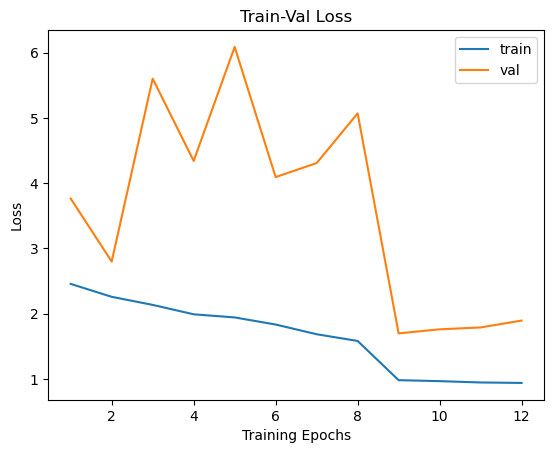

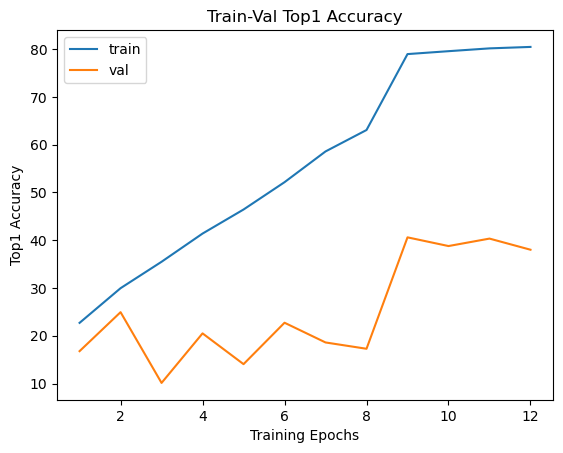

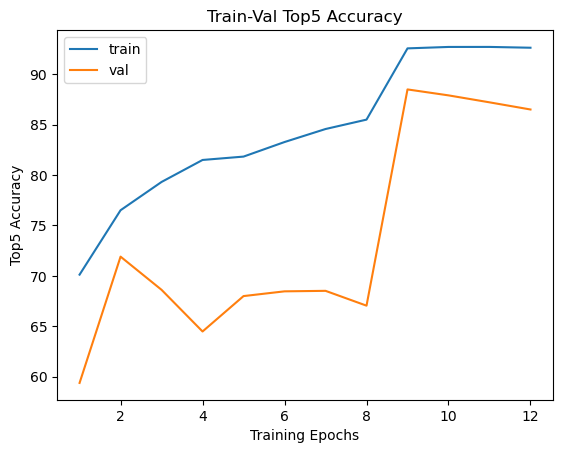

In [22]:
# inference loop를 10번씩 반복할 때 결과
# 현재 loop 안에서는 BN layer의 forward가 실행되지 않으므로
# 한 mini batch당 3번 forward 계산 
# BN mometum = 0.001

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


In [17]:
# inference loop를 25번씩 반복할 때 결과
# epoch 7,8 은 BN mometum을 0.1에서 0.01로 변경

print(loss_hist)
print(acc_hist)
print(total_num_epochs)
print(time_hist)

{'train': [2.5540971433258055, 2.3267999728393556, 2.2341071254730225, 2.1250430152893065, 1.9845849306488037, 1.8859565843772887, 1.6182707493209838, 1.4232276056671143], 'val': [2.4798755718231202, 2.8129577869415283, 3.140468267059326, 2.2890511615753173, 3.1190491790771486, 3.255694902038574, 1.9791238750457765, 2.819766474914551]}
{'train_top1': [21.664, 26.378, 30.71, 37.066, 43.678, 50.302, 59.618, 66.994], 'val_top1': [21.17, 22.25, 23.35, 23.75, 17.32, 21.31, 33.11, 29.6], 'train_top5': [68.222, 72.914, 75.49, 77.712, 79.138, 80.342, 83.04, 84.812], 'val_top5': [73.41, 73.09, 65.55, 77.07, 76.64, 77.29, 84.33, 73.42]}
8
['0:56:14', '0:55:51', '0:56:12', '0:55:57', '0:55:57', '0:57:59', '0:33:14', '0:33:16']


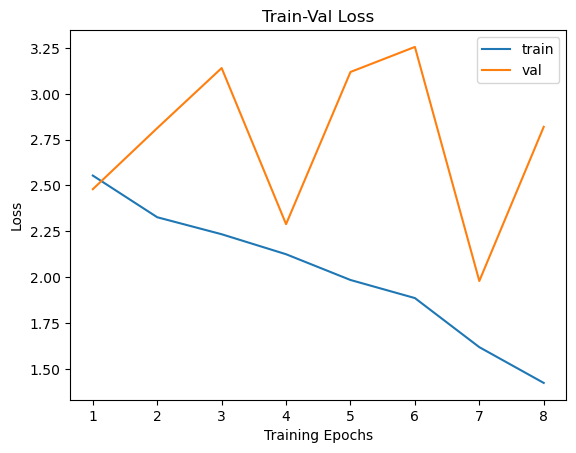

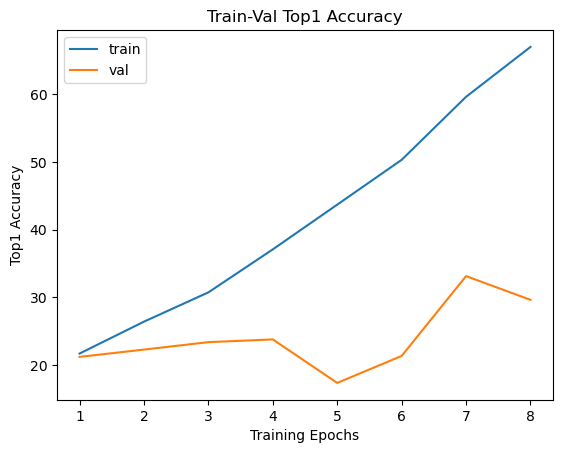

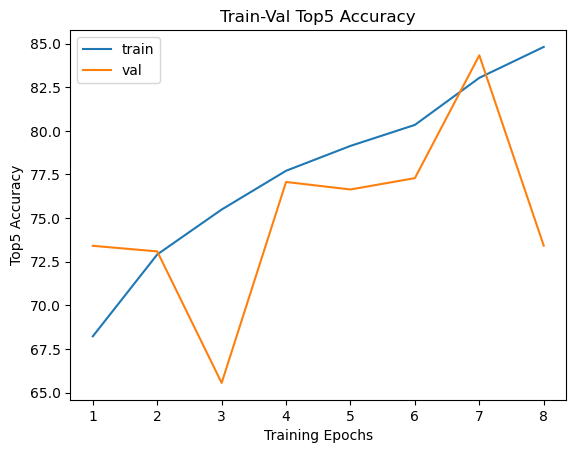

In [18]:
# inference loop를 25번씩 반복할 때 결과
# epoch 7,8 은 BN mometum을 0.1에서 0.01로 변경

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# batch_size가 비교적 작은 32인데 비해 momentum이 0.1이라 running_estimates에 문제가 있어서 val 성능 하락?
# momentum 0.01로 변경? => 0.1에서 0.01로 변경하면 val loss와 val acc 개선 ==> 0.001?
# 또는 nn.BatchNorm2d의 track_running_stats=False 와 같이 문제가 있는 running_estimates들을 버리고 test셋도 batch별로 mean과 var를 계산?
# 또는 overfitting?

In [16]:
# running_mean과 running_var를 사용하지 않고 valiation 해보기
model.train()
for block in model.conv2_x.blocks:
    block.train()
for block in model.conv3_x.blocks:
    block.train()
for block in model.conv4_x.blocks:
    block.train()
for block in model.conv5_x.blocks:
    block.train()

with torch.no_grad():
    val_loss, val_acc1, val_acc5 = loss_epoch(
        model=model,
        data_loader=val_loader,
        sanity_check=False,
        is_training=False,
    )

print(val_loss)
print(val_acc1)
print(val_acc5)

# running_mean, running_var를 사용하지 않아도 validation 성능이 안좋음

==>> len_data: 10000
2.650700281715393
22.8
78.34
